In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10, 10)

from scipy.optimize import linprog

import matplotlib.pyplot as plt
import numpy as np

### Least Squares is not Robust to Outliers

Here we'll generate some fake data in one dimension. 

The $(x, y)$ pairs are generated from choosing random points on a line and then adding some noise to y. In this case the noise is drawn from a Gaussian distribution with mean $0$ and variance $0.01$. For one point, we'll add an extra noise of $0.8$. Thus, this one point stands out from all of the others as seen from the plot.

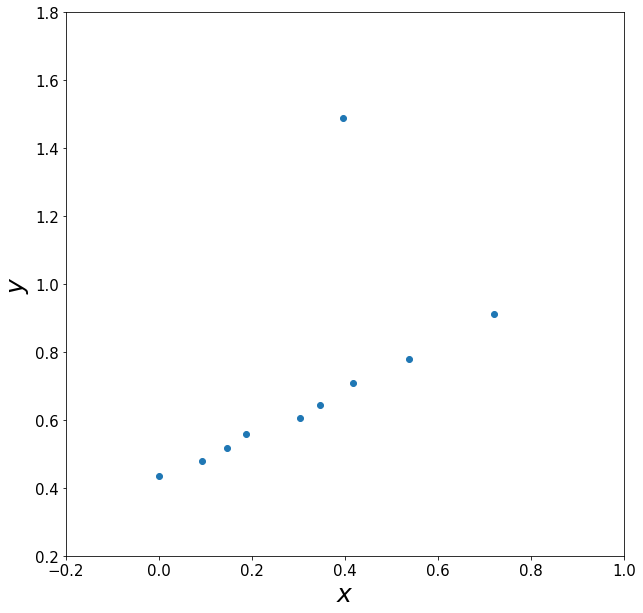

In [2]:
# Generate some fake one-dimensional data
np.random.seed(1)
N = 10
D = 1
x = np.random.rand(N, D)
## Add an extra column of ones to capital X matrix
X = np.c_[np.ones(N), x]
w_true = np.random.rand(D + 1)
sigma2 = 0.01
y = np.dot(X, w_true) + np.random.randn(N) * sigma2

# Make one point an outlier
ol_index = 8
y[ol_index] += .8

# Make the plot
xmin, xmax = -0.2, 1
ymin, ymax = 0.2, 1.8
fig  = plt.figure(1)
ax = plt.subplot(111)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$y$', fontsize=25)

plt.scatter(x, y, label='data')
plt.show()

### Find the least squares estimate

Here, we simply apply the least squares estimate derived in the lecture. 

We then also plot the least squares line and see how the outlier causes the line to shift. Just for the sake of comparison, we also plot the line obtained by least squares with the outlier removed from the dataset.

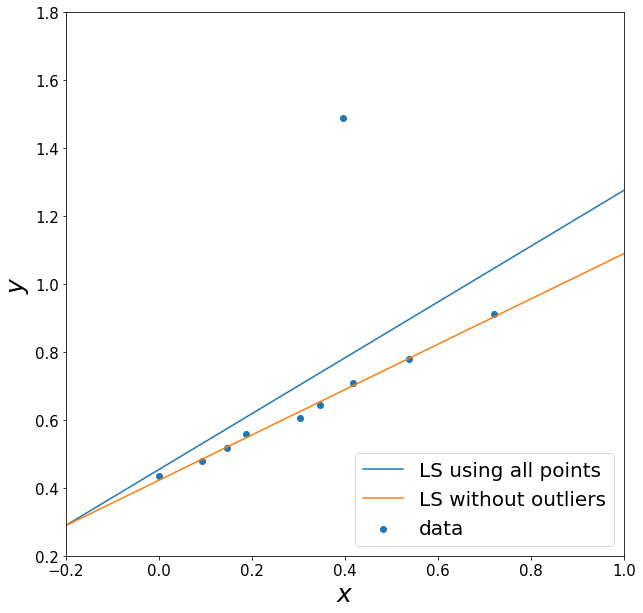

In [3]:
# Find best least square fit on the whole data
w_LS = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

X_nol = np.r_[X[:ol_index, :], X[ol_index + 1:, :]]
y_nol = np.r_[y[:ol_index], y[ol_index + 1:]]
w_nol = np.dot(np.linalg.inv(np.dot(X_nol.T, X_nol)), np.dot(X_nol.T, y_nol))


# Make the plot
xmin, xmax = -0.2, 1
ymin, ymax = 0.2, 1.8
fig  = plt.figure(1)
ax = plt.subplot(111)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$y$', fontsize=25)

plt.scatter(x, y, label='data')
# Let's plot the two regression lines
plt.plot([xmin, xmax], w_LS[0] + w_LS[1] * np.array([xmin, xmax]), label='LS using all points')
plt.plot([xmin, xmax], w_nol[0] + w_nol[1] * np.array([xmin, xmax]), label='LS without outliers')

plt.legend(fontsize='20', loc='lower right')
plt.show()

### Using a different loss function

One of the reasons that the outlier causes the regression to fit a bad model is the loss function used. If instead of minimising $\sum_{i} (y_i - \hat{y}_i)^2$, we try to minimise $\sum_{i} | y_i - \hat{y}_i|$, this problem is less severe.

Unfortunately, there is no closed form solution in this case. It requires solving a linear program. We'll study this in the lectures, for now the plot is shown below. See how even without removing the outlier, the fit produced is quite similar to the one obtained by removing the outlier. Of course, in reality, we'll never know which point is an outlier and which is not!

In [4]:
# Solve using LP
# Create inequality matrix for A_ub * vars <= b_ub
# The first two entries of vars correspond to w_0 and w_1, the remaining N are slack variables
# No equality terms are necessary
A_ub = np.r_[np.c_[X, -np.eye(N)], np.c_[-X, -np.eye(N)], np.c_[np.zeros(X.shape), -np.eye(N)]]
b_ub = np.r_[y, -y, np.zeros(N)].reshape(3 * N, 1)
b_ub = b_ub.reshape( 3 *N , 1)
# The objective only penalises slack variables
c = np.ones([D + 1 + N])
c[:D + 1] = 0

soln = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=[(None, None)]*12)
w_LP = soln['x'][0:D+1]

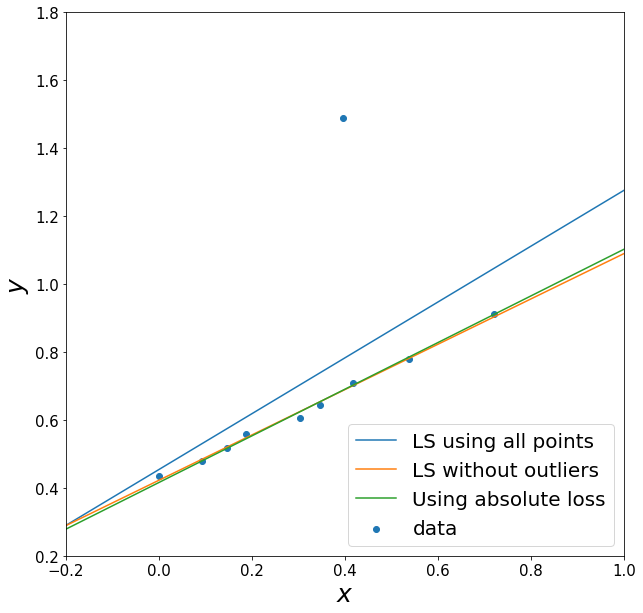

In [5]:
# Make the plot
xmin, xmax = -0.2, 1
ymin, ymax = 0.2, 1.8
fig  = plt.figure(1)
ax = plt.subplot(111)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$y$', fontsize=25)

plt.scatter(x, y, label='data')
# Let's plot the two regression lines
plt.plot([xmin, xmax], w_LS[0] + w_LS[1] * np.array([xmin, xmax]), label='LS using all points')
plt.plot([xmin, xmax], w_nol[0] + w_nol[1] * np.array([xmin, xmax]), label='LS without outliers')
plt.plot([xmin, xmax], w_LP[0] + w_LP[1] * np.array([xmin, xmax]), label='Using absolute loss')
plt.legend(fontsize=20, loc='lower right')
plt.show()